In [1]:
using Printf, DelimitedFiles
using PyCall, PyPlot

include("../pNormDiffusion.jl");

## Load graph and ground truth target cluster

In [2]:
G = read_edgelist("../datasets/LFR_edgelist.txt");
target_cluster = vec(readdlm("../datasets/LFR_target.txt", ' ', Int, '\n'));

## Visualize target cluster

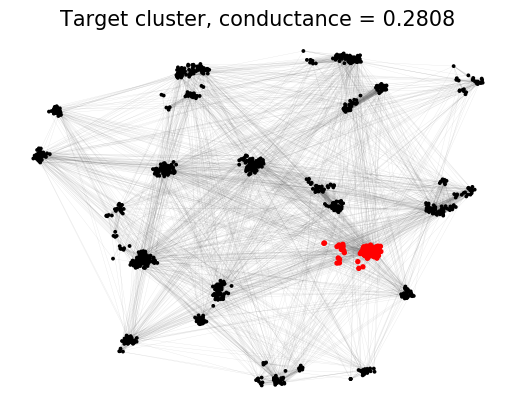

In [3]:
nx = pyimport("networkx");
plt = pyimport("matplotlib.pyplot");

# Load graph to Networkx
g_nx = nx.read_edgelist("../datasets/LFR_edgelist.txt");

# Load pre-computed coordinates for nodes
pos = readdlm("../datasets/LFR_pos.txt", ' ', Float64, '\n');
pos_dict = Dict(string(i) => (xy[1],xy[2]) for (i,xy) in enumerate(eachrow(pos)));

n1 = setdiff(Set(1:1000),Set(target_cluster))
nl = [string(i) for i in n1];
nc = ["k" for _ in n1];
ns = [3 for _ in n1];
for i in target_cluster
    push!(nl, string(i))
    push!(nc, "r")
    push!(ns, 8)
end

plt.subplots()
plt.axes(frameon=false)
nx.draw_networkx_nodes(g_nx, pos_dict, nodelist=nl, node_size=ns, node_color=nc)
nx.draw_networkx_edges(g_nx, pos_dict, width=0.2, edge_color="dimgray", alpha=0.2)
plt.title("Target cluster, conductance = "*@sprintf("%.4f",compute_conductance(G,target_cluster)), size=15)
plt.show()

## Run p-Norm Flow Diffusion and visualize results

In [4]:
seednode = target_cluster[9];
seedmass = 10000 # this is roughly 5 times the volume of target cluster
seedset = Dict(seednode => seedmass);

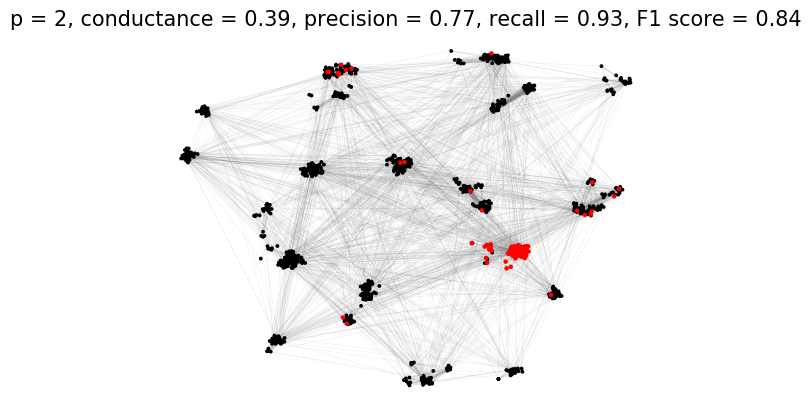

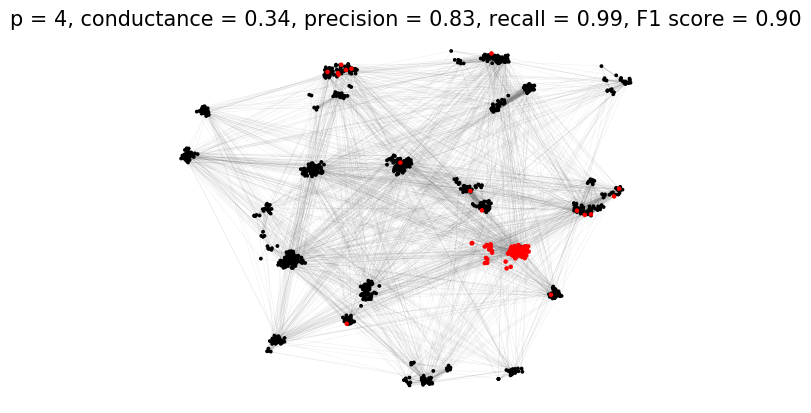

In [5]:
for p in [2,4]
    
    x = pnormdiffusion(G, seedset, p=p, max_iters=100);
    cluster, cond = sweepcut(G, x);
    
    pr, re, f1 = compute_f1(cluster, target_cluster)
    
    n1 = setdiff(Set(1:G.nv),Set(cluster))
    nl = [string(i) for i in n1];
    nc = ["k" for _ in n1];
    ns = [3 for _ in n1];
    for i in cluster
        push!(nl, string(i))
        push!(nc, "r")
        push!(ns, 5)
    end    
    plt.subplots()
    plt.axes(frameon=false)
    plt.title("p = "*string(p)*", conductance = "*@sprintf("%.2f",cond)*
        ", precision = "*@sprintf("%.2f",pr)*", recall = "*@sprintf("%.2f",re)*
        ", F1 score = "*@sprintf("%.2f",f1), size=15) 
    nx.draw_networkx_nodes(g_nx, pos_dict, nodelist=nl, node_size=ns, node_color=nc)
    nx.draw_networkx_edges(g_nx, pos_dict, width=0.2, edge_color="dimgray", alpha=0.2)
    plt.show()
    
end

## Compare with Approximate Personalized PageRank

In [6]:
include("../reproducibility/pagerank.jl");

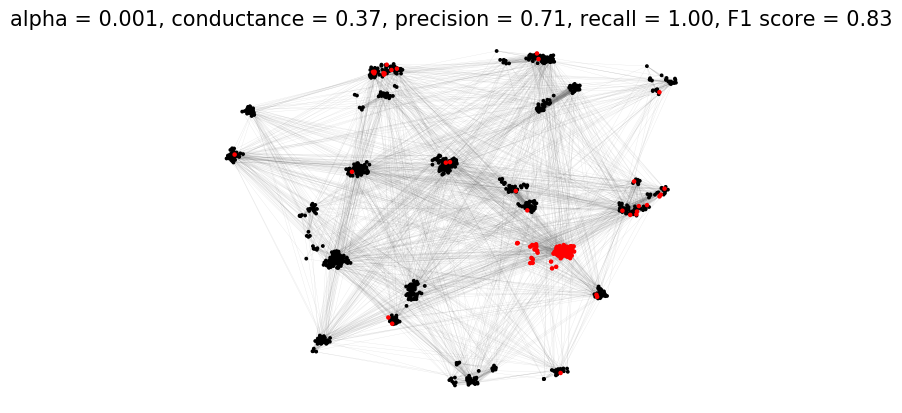

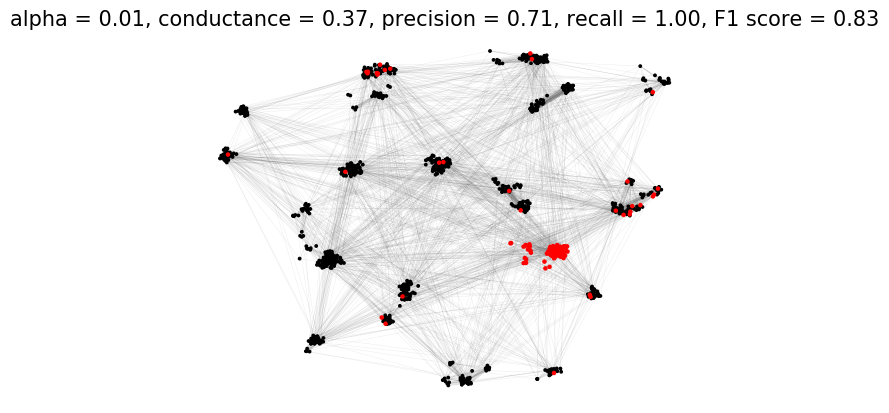

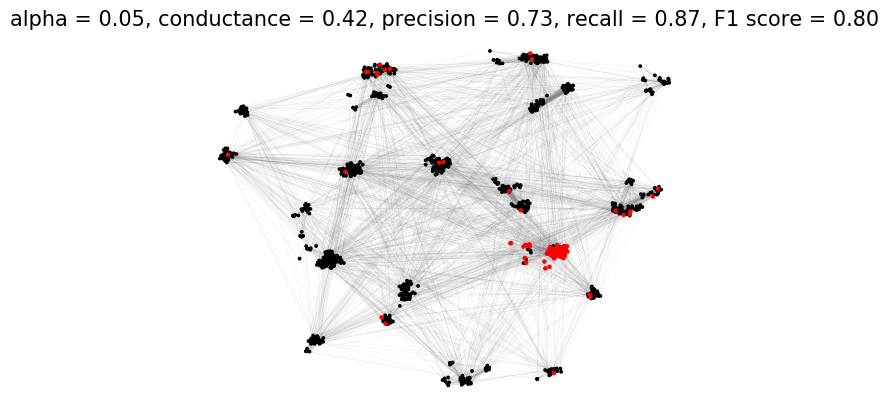

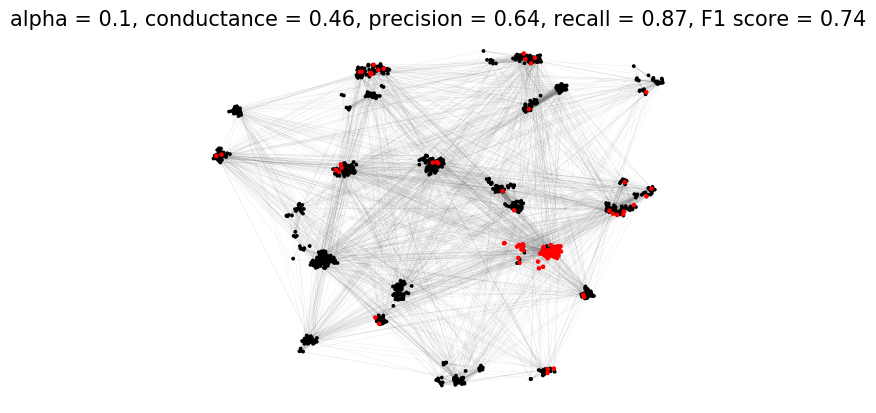

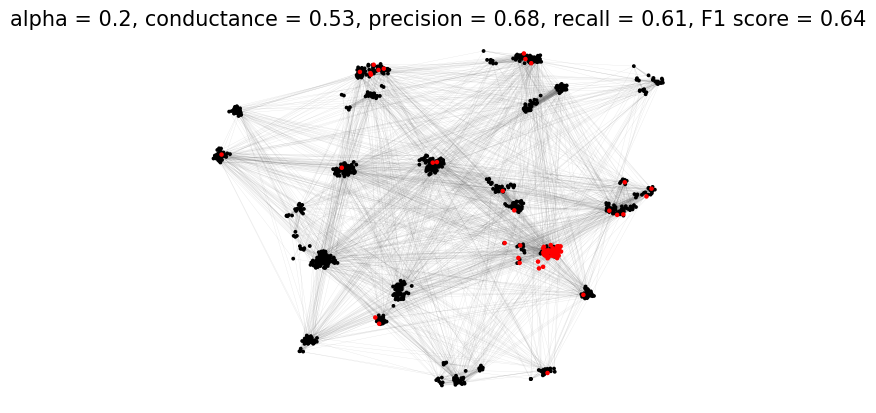

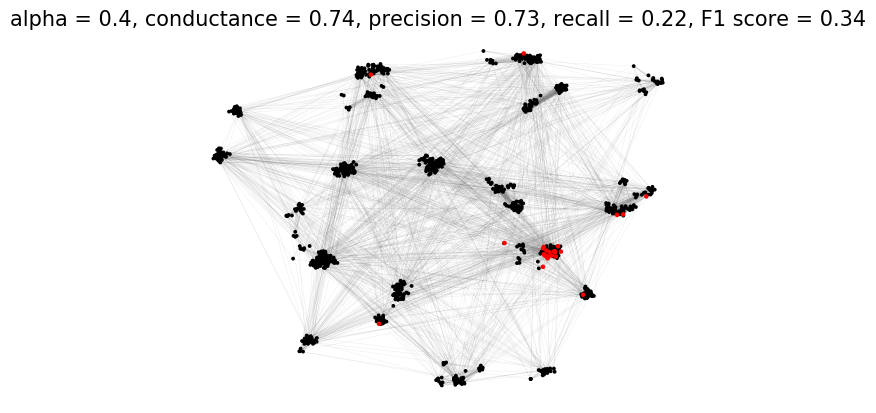

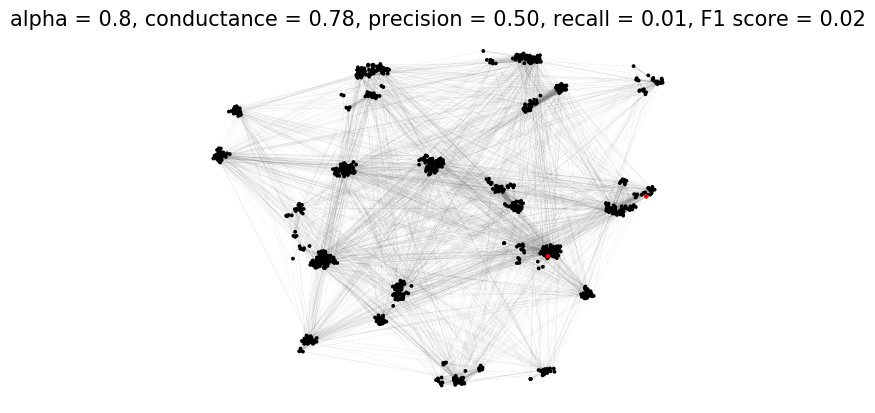

In [7]:
seed_node = target_cluster[9]
s = zeros(G.nv)
s[seed_node] = 1/sqrt(G.degree[seed_node])
rho = 1.0e-4

for alpha in [0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.8]
    p = pagerank(G, s, rho, alpha)
    x = p ./ G.degree
    cluster, cond = sweepcut(G, x)
    
    pr, re, f1 = compute_f1(cluster, target_cluster)
    
    n1 = setdiff(Set(1:G.nv),Set(cluster))
    nl = [string(i) for i in n1];
    nc = ["k" for _ in n1];
    ns = [3 for _ in n1];
    for i in cluster
        push!(nl, string(i))
        push!(nc, "r")
        push!(ns, 5)
    end    
    plt.subplots()
    plt.axes(frameon=false)
    plt.title("alpha = "*string(alpha)*", conductance = "*@sprintf("%.2f",cond)*
        ", precision = "*@sprintf("%.2f",pr)*", recall = "*@sprintf("%.2f",re)*
        ", F1 score = "*@sprintf("%.2f",f1), size=15) 
    nx.draw_networkx_nodes(g_nx, pos_dict, nodelist=nl, node_size=ns, node_color=nc)
    nx.draw_networkx_edges(g_nx, pos_dict, width=0.2, edge_color="dimgray", alpha=0.2)
    plt.show()
    
end